In [15]:
from editsim import *
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [14]:
nrow = 100
mat1 = np.random.randint(0, 10, size = nrow ** 2).reshape(nrow, nrow).astype(np.double)
mat2 = np.random.randint(0, 10, size = nrow ** 2).reshape(nrow, nrow).astype(np.double)

In [21]:
%timeit csimpleeditsim(mat1, mat2)

894 µs ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Simple editsim with bp

In [11]:
def simpleeditsim_withbp(mat1, mat2):
    nrow = mat1.shape[1]
    ncol = mat2.shape[1]
    dp_table = np.zeros((nrow+1, ncol+1))
    bp_table = np.ones_like(dp_table) * (-1)
    for col1 in range(nrow):
        for col2 in range(ncol):
            match = np.dot(mat1[:, col1], mat2[:, col2])
            choices = [
                dp_table[col1, col2 + 1],
                dp_table[col1 + 1, col2],
                dp_table[col1, col2] + match
            ]
            bp_table[col1 + 1, col2 + 1] = np.argmax(choices)
            dp_table[col1 + 1, col2 + 1] = np.max(choices)            
    return dp_table[-1, -1], bp_table

In [38]:
%%cython -a
import numpy as np
cimport cython
cimport numpy as np
DBL = np.double
ctypedef np.double_t DBL_C
cdef inline float float_min2(float a, float b):
    return a if a <= b else b
cdef inline float float_min(float a, float b, float c):
    cdef float d = float_min2(a, b)
    cdef float e = float_min2(b, c)
    return float_min2(d, e)
cdef inline float float_max2(float a, float b):
    return a if a >= b else b
cdef inline float float_max(float a, float b, float c):
    cdef float d = float_max2(a, b)
    cdef float e = float_max2(b, c)
    return float_max2(d, e)
cdef inline int int_max(int a, int b):
    return a if a >= b else b
cdef inline int int_min(int a, int b):
    return a if a <= b else b
cdef struct Pair:
    float value
    int idx
cdef inline Pair indmax(float a, float b, float c):
    cdef Pair pair
    if a >= b:
        if a >= c:
            pair.value = a
            pair.idx = 0
            return pair
        else:
            # b <= a <= c
            pair.value = c
            pair.idx = 2
            return pair
    else:
        # a <= b
        if b >= c:
            # a < b and b > c
            pair.value = b
            pair.idx = 1
            return pair
        else:
            # a < b and b < c
            pair.value = c
            pair.idx = 2
            return pair
        
@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(True)  # turn off negative index wrapping for entire function        
def csimpleeditsim_withbp(DBL_C [:, :] mat1, DBL_C [:, :] mat2):
    cdef int nrow, ncol, nneuron
    cdef int col1, col2, row    
    nrow = mat1.shape[1]
    ncol = mat2.shape[1]
    nneuron = mat1.shape[0]
    cdef np.ndarray[DBL_C, ndim=2] dp_table = np.zeros((nrow+1, ncol+1), dtype = DBL)
    cdef np.ndarray[DBL_C, ndim=2] bp_table = np.ones_like(dp_table, dtype = DBL) * (-1)
    cdef DBL_C match
    for col1 in range(nrow):
        for col2 in range(ncol):
            match = 0
            for row in range(nneuron):
                match += mat1[row, col1] * mat2[row, col2]            
            pair = indmax(
                dp_table[col1, col2 + 1],
                dp_table[col1 + 1, col2],
                dp_table[col1, col2] + match
            )
            bp_table[col1 + 1, col2 + 1] = pair.idx
            dp_table[col1 + 1, col2 + 1] = pair.value
    return dp_table[-1, -1], bp_table
@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(True)  # turn off negative index wrapping for entire function        
def csimpleeditsim_withbp_mod(DBL_C [:, :] mat1, DBL_C [:, :] mat2):
    cdef Py_ssize_t nrow, ncol, nneruon
    cdef Py_ssize_t col1, col2, row    
    nrow = mat1.shape[1]
    ncol = mat2.shape[1]
    nneuron = mat1.shape[0]
    cdef np.ndarray[DBL_C, ndim=2] dp_table = np.zeros((nrow+1, ncol+1), dtype = DBL)
    cdef np.ndarray[DBL_C, ndim=2] bp_table = np.ones_like(dp_table, dtype = DBL) * (-1)
    cdef DBL_C match
    for col1 in range(nrow):
        for col2 in range(ncol):
            match = 0
            for row in range(nneuron):
                match += mat1[row, col1] * mat2[row, col2]            
            pair = indmax(
                dp_table[col1, col2 + 1],
                dp_table[col1 + 1, col2],
                dp_table[col1, col2] + match
            )
            bp_table[col1 + 1, col2 + 1] = pair.idx
            dp_table[col1 + 1, col2 + 1] = pair.value
    return dp_table[-1, -1], bp_table

## Origincal performance

In [21]:
%timeit simpleeditsim_withbp(mat1, mat2)

156 ms ± 18.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Cythonized Performance

In [44]:
%timeit csimpleeditsim_withbp(mat1, mat2)

1.78 ms ± 217 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [45]:
%timeit csimpleeditsim_withbp_mod(mat1, mat2)

1.82 ms ± 227 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
print(csimpleeditsim_withbp(mat1, mat2), "\n", simpleeditsim_withbp(mat1, mat2))

(202170.0, array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1.,  2.,  2., ...,  1.,  1.,  1.],
       [-1.,  2.,  2., ...,  1.,  1.,  1.],
       ..., 
       [-1.,  0.,  0., ...,  2.,  2.,  2.],
       [-1.,  0.,  0., ...,  2.,  2.,  2.],
       [-1.,  0.,  2., ...,  2.,  2.,  2.]])) 
 (202170.0, array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1.,  2.,  2., ...,  1.,  1.,  1.],
       [-1.,  2.,  2., ...,  1.,  1.,  1.],
       ..., 
       [-1.,  0.,  0., ...,  2.,  2.,  2.],
       [-1.,  0.,  0., ...,  2.,  2.,  2.],
       [-1.,  0.,  2., ...,  2.,  2.,  2.]]))


In [28]:
sim, bp = csimpleeditsim_withbp(mat1, mat2)

In [46]:
np.py_ssize_t

AttributeError: module 'numpy' has no attribute 'py_ssize_t'

# simple editsim align bp

In [34]:
def simpleeditsim_align(bp, mat1, mat2):
    nrow = bp.shape[0]
    ncol = bp.shape[1]
    row = nrow - 1
    col = ncol - 1
    # The first column is inserted just to avoid initialization error that may occur on concatination.
    alignment1 = np.zeros((mat1.shape[0], 1))
    alignment2 = np.zeros((mat1.shape[0], 1))
    zerovec = np.zeros(mat1.shape[0]) # which is corresponding to the null character.
    while True:
        if bp[row, col] == -1:
            # Eather of the strings tracing terminated
            break
        elif bp[row, col] == 2:
            alignment1 = np.c_[mat1[:, row - 1] * mat2[:, col - 1], alignment1]
            alignment2 = np.c_[mat1[:, row - 1] * mat2[:, col - 1], alignment2]
            row -= 1
            col -= 1
        elif bp[row, col] == 1:
            alignment1 = np.c_[zerovec, alignment1]
            alignment2 = np.c_[mat2[:, col - 1], alignment2]
            col -= 1
        elif bp[row, col] == 0:
            alignment1 = np.c_[mat1[:, row - 1], alignment1]
            alignment2 = np.c_[zerovec, alignment2]
            row -= 1
    return alignment1[:, :-1], alignment2[:, :-1]

In [30]:
simpleeditsim_align(bp, mat1, mat2)

(array([[ 10.,  36.,  21., ...,   0.,  45.,  24.],
        [  8.,   5.,  28., ...,  27.,  24.,   4.],
        [ 56.,   3.,  48., ...,   8.,  35.,  12.],
        ..., 
        [  0.,   0.,   6., ...,  32.,  40.,  27.],
        [  0.,  16.,  36., ...,   0.,   0.,   6.],
        [  6.,  15.,   8., ...,   6.,  56.,  24.]]),
 array([[ 10.,  36.,  21., ...,   0.,  45.,  24.],
        [  8.,   5.,  28., ...,  27.,  24.,   4.],
        [ 56.,   3.,  48., ...,   8.,  35.,  12.],
        ..., 
        [  0.,   0.,   6., ...,  32.,  40.,  27.],
        [  0.,  16.,  36., ...,   0.,   0.,   6.],
        [  6.,  15.,   8., ...,   6.,  56.,  24.]]))

In [35]:
%timeit simpleeditsim_align(bp, mat1, mat2)

5.08 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
%%cython -a
import numpy as np
cimport cython
cimport numpy as np
DBL = np.double
ctypedef np.double_t DBL_C
cdef inline float float_min2(float a, float b):
    return a if a <= b else b
cdef inline float float_min(float a, float b, float c):
    cdef float d = float_min2(a, b)
    cdef float e = float_min2(b, c)
    return float_min2(d, e)
cdef inline float float_max2(float a, float b):
    return a if a >= b else b
cdef inline float float_max(float a, float b, float c):
    cdef float d = float_max2(a, b)
    cdef float e = float_max2(b, c)
    return float_max2(d, e)
cdef inline int int_max(int a, int b):
    return a if a >= b else b
cdef inline int int_min(int a, int b):
    return a if a <= b else b
cdef struct Pair:
    float value
    int idx
cdef inline Pair indmax(float a, float b, float c):
    cdef Pair pair
    if a >= b:
        if a >= c:
            pair.value = a
            pair.idx = 0
            return pair
        else:
            # b <= a <= c
            pair.value = c
            pair.idx = 2
            return pair
    else:
        # a <= b
        if b >= c:
            # a < b and b > c
            pair.value = b
            pair.idx = 1
            return pair
        else:
            # a < b and b < c
            pair.value = c
            pair.idx = 2
            return pair
        
@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(True)  # turn off negative index wrapping for entire function        
def csimpleeditsim_align(bp, mat1, mat2):
    cdef int nrow, ncol, nneuron
    cdef int col1, col2, row, col
    nrow = bp.shape[0]
    ncol = bp.shape[1]
    row = nrow - 1
    col = ncol - 1
    # The first column is inserted just to avoid initialization error that may occur on concatination.
    cdef np.ndarray[DBL_C, ndim=2] alignment1 = np.zeros((mat1.shape[0], 1), dtype = DBL)
    cdef np.ndarray[DBL_C, ndim=2] alignment2 = np.zeros((mat1.shape[0], 1), dtype = DBL)
    cdef np.ndarray[DBL_C, ndim=2] zerovec = np.zeros(mat1.shape[0], dtype = DBL) # which is corresponding to the null character.
    while True:
        if bp[row, col] == -1:
            # Eather of the strings tracing terminated
            break
        elif bp[row, col] == 2:
            alignment1 = np.c_[mat1[:, row - 1] * mat2[:, col - 1], alignment1]
            alignment2 = np.c_[mat1[:, row - 1] * mat2[:, col - 1], alignment2]
            row -= 1
            col -= 1
        elif bp[row, col] == 1:
            alignment1 = np.c_[zerovec, alignment1]
            alignment2 = np.c_[mat2[:, col - 1], alignment2]
            col -= 1
        elif bp[row, col] == 0:
            alignment1 = np.c_[mat1[:, row - 1], alignment1]
            alignment2 = np.c_[zerovec, alignment2]
            row -= 1
    return alignment1[:, :-1], alignment2[:, :-1]

In [37]:
%timeit simpleeditsim_align(bp, mat1, mat2)

4.99 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Local alignment with linear gap penalty

In [2]:
%load_ext cython

In [3]:
%%cython -a
import numpy as np
cimport cython
cimport numpy as np
from libc.math cimport exp
DBL = np.double
ctypedef np.double_t DBL_C

cdef inline DBL_C cexp(DBL_C a):
    return exp(a)
cdef inline npexp(DBL_C a):
    return np.exp(a)
def exp_test(DBL_C a, flag):
    if flag:
        exp(a)
    else:
        npexp(a)

In [4]:
DBL = np.double
a = np.array([0.1], dtype = DBL)

In [5]:
%timeit exp_test(a[0], True)

181 ns ± 22 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [6]:
%timeit exp_test(a[0], False)

827 ns ± 2.28 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [49]:
def local_exp_editsim(mat1, mat2, a = 0.01):
    nrow = mat1.shape[1]
    ncol = mat2.shape[1]
    dp = np.zeros((nrow+1, ncol+1))
    dp_max = 0
    dp_max_x = -1
    dp_max_y = -1
    down = np.zeros((nrow+1, ncol+1), dtype=np.int)
    right = np.zeros((nrow+1, ncol+1), dtype=np.int)
    for col1 in range(nrow):
        for col2 in range(ncol):
            match = np.dot(mat1[:, col1], mat2[:, col2])
            # For Down
            # Comparing options: newly extend a gap or extend the exsinting gap
            which_dir = np.argmax([
                dp[col1, col2+1] - np.exp(a) + 1,
                dp[col1-down[col1, col2+1], col2+1] - np.exp(a*(down[col1, col2+1] + 1)) + 1
            ])
            down[col1+1, col2+1] = 1 if which_dir == 0 else down[col1, col2+1] + 1
            down_score = dp[col1-down[col1+1, col2+1]+1, col2+1] - np.exp(a*down[col1+1, col2+1]) + 1
            # For Rightp
            # Comparing options: newly extend a gap or extend the exsinting gap
            which_dir = np.argmax([
                dp[col1+1, col2] - np.exp(a) + 1,
                dp[col1+1, col2-right[col1+1, col2]] - np.exp(a*(right[col1+1, col2] + 1)) + 1
            ])
            right[col1+1, col2+1] = 1 if which_dir == 0 else right[col1+1, col2] + 1
            right_score = dp[col1+1, col2-right[col1+1, col2+1]+1] - np.exp(a*right[col1+1, col2+1]) + 1
            # Update dp
            dp[col1+1, col2+1] = np.max([
                0,
                down_score,
                right_score,
                dp[col1, col2] + match
            ])
            if dp[col1+1, col2+1] > dp_max:
                dp_max = dp[col1+1, col2+1]
                dp_max_x = col1 + 1
                dp_max_y = col2 + 1
    return dp_max, dp_max_x, dp_max_y

In [80]:
%%cython -a
import numpy as np
cimport cython
cimport numpy as np
DBL = np.double
ctypedef np.double_t DBL_C
INT = np.int
ctypedef np.int_t INT_C
cdef inline float float_min2(float a, float b):
    return a if a <= b else b
cdef inline float float_min(float a, float b, float c):
    cdef float d = float_min2(a, b)
    cdef float e = float_min2(b, c)
    return float_min2(d, e)
cdef inline float float_max2(float a, float b):
    return a if a >= b else b
cdef inline float float_max(float a, float b, float c):
    cdef float d = float_max2(a, b)
    cdef float e = float_max2(b, c)
    return float_max2(d, e)
cdef inline int int_max(int a, int b):
    return a if a >= b else b
cdef inline int int_min(int a, int b):
    return a if a <= b else b
cdef struct Pair:
    float value
    int idx
cdef inline Pair indmax(float a, float b, float c):
    cdef Pair pair
    if a >= b:
        if a >= c:
            pair.value = a
            pair.idx = 0
            return pair
        else:
            # b <= a <= c
            pair.value = c
            pair.idx = 2
            return pair
    else:
        # a <= b
        if b >= c:
            # a < b and b > c
            pair.value = b
            pair.idx = 1
            return pair
        else:
            # a < b and b < c
            pair.value = c
            pair.idx = 2
            return pair
cdef inline Pair indmax2(float a, float b):
    cdef Pair pair
    if a >= b:
        pair.value = a
        pair.idx = 0
        return pair
    else:
        pair.value = b
        pair.idx = 1
        return pair
        
def local_exp_editsim(DBL_C[:, :] mat1, DBL_C[:, :] mat2, float a = 0.01):
    cdef int nrow, ncol, nneuron
    cdef int col1, col2, row      
    nrow = mat1.shape[1]
    ncol = mat2.shape[1]
    nneuron = mat1.shape[0]
    cdef np.ndarray[DBL_C, ndim=2] dp = np.zeros((nrow+1, ncol+1), dtype = DBL)
    cdef DBL_C dp_max = 0
    cdef int dp_max_x = -1
    cdef int dp_max_y = -1
    cdef np.ndarray[INT_C, ndim=2] down = np.zeros((nrow+1, ncol+1), dtype = INT)
    cdef np.ndarray[INT_C, ndim=2] right = np.zeros((nrow+1, ncol+1), dtype = INT)
    cdef DBL_C match
    for col1 in range(nrow):
        for col2 in range(ncol):
            match = 0
            for row in range(nneuron):
                match += mat1[row, col1] * mat2[row, col2]            
            # For Down
            # Comparing options: newly extend a gap or extend the exsinting gap
            which_dir = indmax2(
                dp[col1, col2+1] - np.exp(a) + 1,
                dp[col1-down[col1, col2+1], col2+1] - np.exp(a*(down[col1, col2+1] + 1)) + 1
            )
            down[col1+1, col2+1] = 1 if which_dir == 0 else down[col1, col2+1] + 1
            down_score = dp[col1-down[col1+1, col2+1]+1, col2+1] - np.exp(a*down[col1+1, col2+1]) + 1
            # For Rightp
            # Comparing options: newly extend a gap or extend the exsinting gap
            which_dir = indmax2(
                dp[col1+1, col2] - np.exp(a) + 1,
                dp[col1+1, col2-right[col1+1, col2]] - np.exp(a*(right[col1+1, col2] + 1)) + 1
            )
            right[col1+1, col2+1] = 1 if which_dir == 0 else right[col1+1, col2] + 1
            right_score = dp[col1+1, col2-right[col1+1, col2+1]+1] - np.exp(a*right[col1+1, col2+1]) + 1
            # Update dp
            dp[col1+1, col2+1] = float_max(
                0,
                down_score,
                right_score,
                dp[col1, col2] + match
            )
            if dp[col1+1, col2+1] > dp_max:
                dp_max = dp[col1+1, col2+1]
                dp_max_x = col1 + 1
                dp_max_y = col2 + 1
    return dp_max, dp_max_x, dp_max_y        

In [50]:
local_exp_editsim(mat1, mat2)

(201680.0, 100, 100)

In [55]:
sequence = np.eye(5)
mat1 = np.zeros((5, 10))
mat2 = np.zeros((5, 10))
mat1[:, 0:5] = sequence[:, :]
mat2[:, 5:10] = sequence[:, :]

In [56]:
mat1

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [57]:
mat2

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [58]:
local_exp_editsim(mat1, mat2)

(5.0, 5, 10)

In [72]:
sequence = np.eye(5)
mat1 = np.zeros((5, 10))
mat2 = np.zeros((5, 20))
mat1[:, 0:5] = sequence[:, :]
mat2[:, [5, 16, 17, 18, 19]] = sequence[:, :]

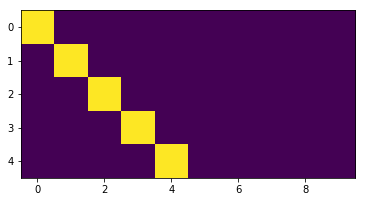

In [73]:
plt.imshow(mat1)

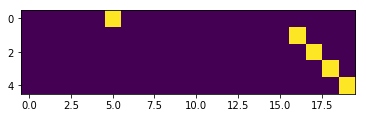

In [74]:
plt.imshow(mat2)

In [76]:
local_exp_editsim(mat1, mat2, a=0.01)

(4.8994983291583205, 5, 20)

In [77]:
local_exp_editsim(mat2, mat1, a=0.01)

(4.8994983291583205, 20, 5)